<a href="https://colab.research.google.com/github/gpulina/GPS-Distance-Duration/blob/main/housing_max_peter_thomas_michael_me_numba_jit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import jit, float64
from numba.experimental import jitclass
import scipy.stats as stats

#1 Using the search model to describe the problem of buying a property

The objective is to calculate the reservation price and acceptance probability. In this case the Reservation price would represent the maximum acceptable purchase price that the renter is willing to accept based on expected future offers.  

Reservation Threshold: The reservation value now represents the maximum price a renter is willing to accept based on expected future offers, given the opportunity cost of continuing the search.

Some notes:

1. Renting Living Cost (r): This represents the cost of living without purchasing the offered property.
2. Home Offer Prices (p_draws): This represents the set of offered prices or rents that the renter is considering.
3. The Discount Factor (β) represents how the renter values future offers relative to current offers.
4. Distribution Parameters (μ and σ) could represent the mean and standard deviation of home offer prices if we model this as a N. An alternative is a log-normal distribution if high-end homes are more common and prices are skewed, we might still prefer a lognormal distribution.


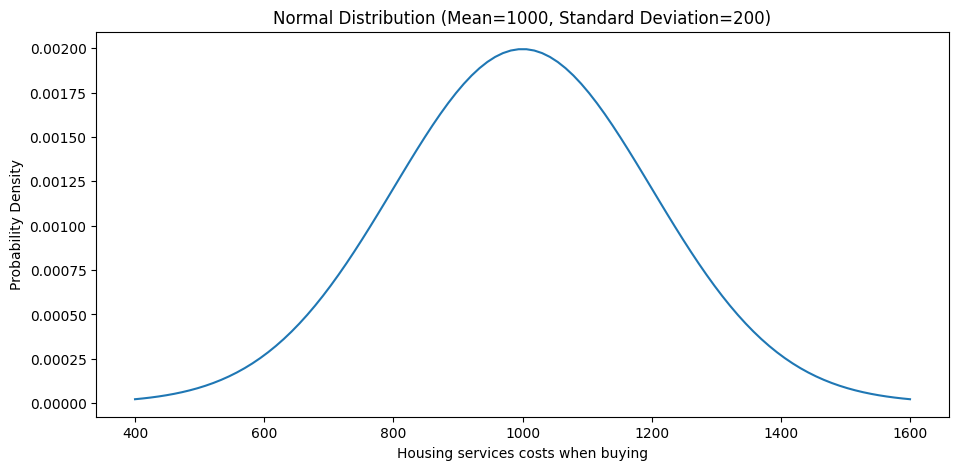

In [2]:
# Generate data points for the normal distribution
mu = 1000  # Mean
sigma = 200  # Standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)  # Range of x-values
y = stats.norm.pdf(x, mu, sigma)  # Probability density function

# Create the plot
plt.plot(x, y)
plt.title('Normal Distribution (Mean=1000, Standard Deviation=200)')
plt.xlabel('Housing services costs when buying')
plt.ylabel('Probability Density')
plt.show()

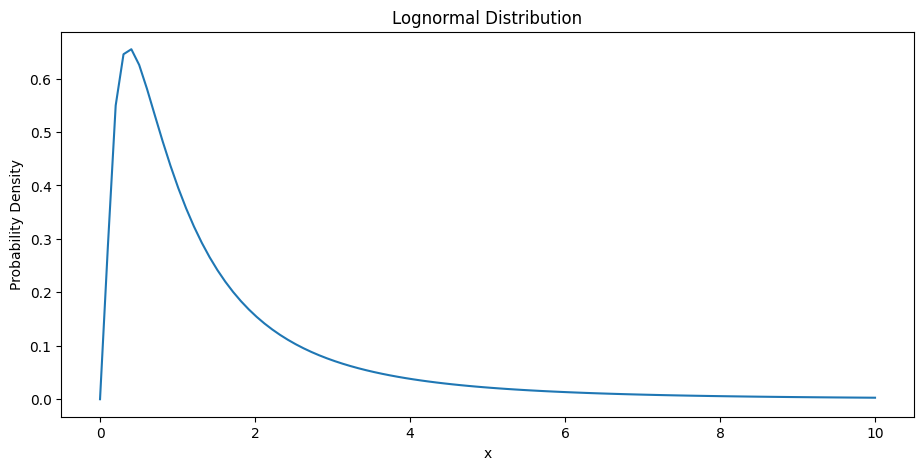

In [3]:
# Generate data points for the lognormal distribution
mu = 0  # Mean of the underlying normal distribution
sigma = 1  # Standard deviation of the underlying normal distribution
x = np.linspace(0, 10, 100)  # Range of x-values
y = stats.lognorm.pdf(x, s=sigma, scale=np.exp(mu))  # Probability density function

# Create the plot
plt.plot(x, y)
plt.title('Lognormal Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.show()

In [4]:
model_data_cont = [
    ('r', float64),          # renting living cost
    ('β', float64),          # discount factor
    ('σ', float64),          # standard deviation in home offer distribution
    ('μ', float64),          # mean in home offer distribution
    ('sr', float64),         # goverment subsidy when renting
    ('sb', float64),         # goverment subsidy when owning
    ('p_draws', float64[:])  # draws of home offers for Monte Carlo
]


In [ ]:
@jitclass(model_data_cont)
class RentalModelCont:

    def __init__(self, r=800, β=0.99, σ=200, μ=1000, sr=0, sb=0, mc_size=1000):
        self.r, self.β, self.σ, self.μ, self.sr, self.sb = r, β, σ, μ, sr, sb

        # Draw and store home offer prices from a normal distribution
        np.random.seed(1234)
        self.p_draws = np.random.normal(loc=μ, scale=σ, size=mc_size)


In [ ]:
@jit(nopython=True)
def compute_reservation_price_cont(model, max_iter=500, err=1e-5):
    r, β, σ, μ, sr, sb, p_draws = model.r, model.β, model.σ, model.μ, model.sr, model.sb, model.p_draws

    # initial guess for reservation price
    v = (np.mean(p_draws)*(1-sb)) / (1 - β)
    i = 0
    error = err + 1

    # Iteratively solve for the reservation price
    while i < max_iter and error > err:
        igral = np.mean(np.minimum((p_draws*(1-sb)) / (1 - β), v))
        v_next = r*(1-sr) + β * igral

        error = np.abs(v_next - v)
        v = v_next
        i += 1

    # Calculate the probability of acceptance
    reservation_price = (1 - β) * v / (1 - sb)

    # Calculate the probability of acceptance
    acceptance_probability = np.mean(p_draws <= reservation_price)

    # Return the reservation price, which is the maximum price willing to pay, and the probability of acceptance
    return (reservation_price, acceptance_probability)


In [ ]:
grid_size = 25
R = np.empty((grid_size, grid_size))
Pr = np.empty((grid_size, grid_size))

r_vals = np.linspace(500.0, 1500.0, grid_size)
β_vals = np.linspace(0.1, 0.99, grid_size)

sb = 0.3
sr = 0
for i, r in enumerate(r_vals):
    for j, β in enumerate(β_vals):
        mcmc = RentalModelCont(r=r, β=β, sr=sr,sb=sb)
        R[i, j] = compute_reservation_price_cont(mcmc)[0]
        Pr[i, j] = compute_reservation_price_cont(mcmc)[1]

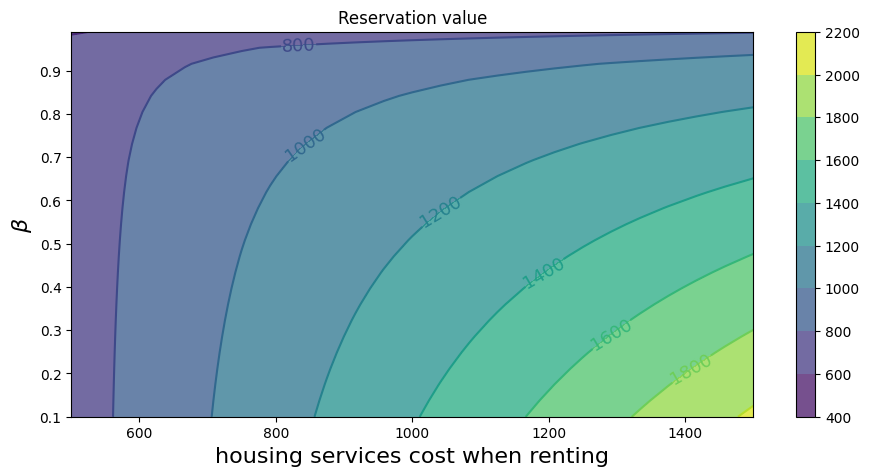

In [ ]:
fig, ax = plt.subplots()

cs1 = ax.contourf(r_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(r_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("Reservation value")
ax.set_xlabel("housing services cost when renting", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()


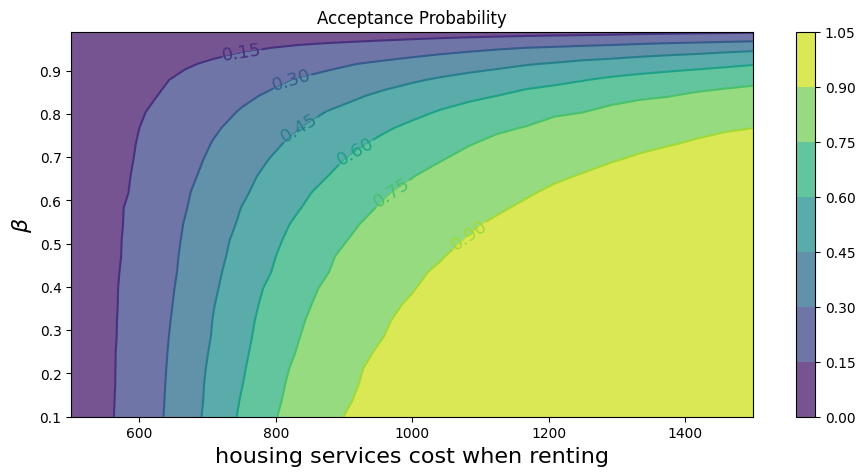

In [ ]:
fig, ax = plt.subplots()

cs1 = ax.contourf(r_vals, β_vals, Pr.T, alpha=0.75)
ctr1 = ax.contour(r_vals, β_vals, Pr.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("Acceptance Probability")
ax.set_xlabel("housing services cost when renting", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()